In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use(['science', 'notebook', 'grid'])
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import hilbert
from tqdm import tqdm
import os
## Some Functions
from tensorflow.keras import backend as K

In [3]:
def GetSignalNoiseWindows(Trace, signalLength=800, noiseLength=1600, totalLength=4000, minGap=200):
    '''
    Returns the values where the signal window start and stops and where the nose window starts and stops
    given the location of the middle of the signal.
    '''
    signalMiddle = np.argmax(np.abs(Trace))
#     signalMiddle = np.argmax(np.abs(hilbert(Trace)))
    
    # print(f'len(Trace), signalMiddle, Trace[signalMiddle]={len(Trace), signalMiddle, Trace[signalMiddle]}')
    # print(f'signalLength={signalLength}')
    # print(f'noiseLength={noiseLength}')
    # print(f'totalLength={totalLength}')
    # print(f'len(Trace)= {len(Trace)}')
    # print(f'signalMiddle={signalMiddle}')
    
    if totalLength <= 0:
        print("The waveform length does not look right! ({})".format(totalLength))

    if signalMiddle >= totalLength:
        print("The signal middle ({}) is beyond the end of the waveform ({})".format(signalMiddle, totalLength))

    if signalLength + noiseLength + minGap > totalLength:
        print("You cannot fit a signal window ({}) and noise window ({}) with a gap of ({}) inside a waveform of length ({})". format(
          signalLength, noiseLength, minGap, totalLength))

    signalStart = signalMiddle - int(signalLength / 2)

    if signalStart < 0:
        signalStart = 0

    signalStop = signalStart + signalLength - 1
    if signalStop >= totalLength:
        signalStart -= signalStop - totalLength - 1
        signalStop = totalLength - 1

    #Put the noise window on the side of the signal window with more room
    if signalStart > (totalLength - signalStop): #More room at the beginning
        noiseMid = int((signalStart - minGap)/2)
        noiseStart = max(noiseMid - int(noiseLength/2), 0) #Don't go below zero
        noiseStop = min(noiseStart + noiseLength - 1, signalStart - minGap - 1) #Don't overlap with signal

    else: #More room at the end
        noiseMid = int((totalLength + minGap + signalStop) / 2)
        noiseStart = max(noiseMid - int(noiseLength/2), minGap + signalStop + 1)
        noiseStop = min(noiseStart + noiseLength - 1, totalLength - 1)

    #They should not overlap
    assert(not (signalStart <= noiseStart <= signalStop))
    assert(not (signalStart <= noiseStop <= signalStop))

#     print(f'int(signalStart), int(signalStop), int(noiseStart), int(noiseStop)={int(signalStart), int(signalStop), int(noiseStart), int(noiseStop)}')
    return int(signalStart), int(signalStop), int(noiseStart), int(noiseStop)



def GetSNR(Trace):
    '''
    Return the Signal to Noise Ratio. Signal is just the peak of the trace.
    Medain RMS of chunck of trace. 
    '''
    from scipy.signal import hilbert
    SigPeak = np.max(np.abs(hilbert(Trace))) # Can also use abs value instead of hilbert 
    Chunks = np.array_split(Trace, 10)  # Split the trace in to 10 small chunks
    ChunkRMS_squared = [(sum(chunk**2))/len(chunk) for chunk in Chunks] ## RMS^2 of each chunk
    RMS_Median = np.median(ChunkRMS_squared) ## Chunk with signal in it.
    return SigPeak**2/RMS_Median 

def CorrCoeff(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = mx
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    return r

# Custom correlation metric
def CC2(y_true, y_pred):
    def pearson_correlation(x, y):
        mean_x = K.mean(x)
        mean_y = K.mean(y)
        cov_xy = K.sum((x - mean_x) * (y - mean_y))
        std_x = K.sqrt(K.sum(K.square(x - mean_x)))
        std_y = K.sqrt(K.sum(K.square(y - mean_y)))
        correlation = cov_xy / (std_x * std_y)
        return correlation

    correlation = tf.py_function(pearson_correlation, [y_true, y_pred], tf.float32)
    return correlation

def Normalize(signals):
    # Normalization
    Normalized_Trace = []
    ScaleFactor = []
    for sig in signals:
        i_m = np.max(abs(sig))
        Normalized_Trace.append(np.array(sig) / i_m)
        ScaleFactor.append(i_m)
    # print('Size of dataset', np.asarray(Normalized_Trace).shape)
    return np.asarray(Normalized_Trace), np.asarray(ScaleFactor)

def GetOutput(Traces, Classifier): ## get the predicted classifier output for the input traces
    Traces = np.array(Traces)
    predict = Classifier.predict(Traces)
    y_predict = predict.reshape(predict.shape[0],)
    return y_predict

def ComputePercentPositives(Bin, Threshold=0.5):
    BinLen = len(Bin)
    Positives = 0
    for i in range(BinLen):
        if Bin[i] >= Threshold:
            Positives += 1
    return (Positives / BinLen) * 100


def GetPowerRatio(y_true, y_pred):
    ## Find the Noise and Signal Windows
#     if dataset=='v11':
#         signalStart, signalStop, noiseStart, noiseStop = GetSignalNoiseWindows(y_true, signalLength=200, noiseLength=400, totalLength=1000, minGap=50)
#     else:
#         signalStart, signalStop, noiseStart, noiseStop = GetSignalNoiseWindows(y_true)
    # print(f'len(y_true)={len(y_true)}')
    # print(f'len(y_pred)={len(y_pred)}')
    signalStart, signalStop, noiseStart, noiseStop = GetSignalNoiseWindows(y_true, signalLength=200, noiseLength=400, totalLength=1000, minGap=50)
    # print(f'signalStart, signalStop, noiseStart, noiseStop = {signalStart, signalStop, noiseStart, noiseStop}')
    def Power(voltages):
        ## Get Power in two windows
        signal_window = voltages[signalStart : signalStop]  ## window where the signal should be
        noise_window = voltages[noiseStart : noiseStop]        
 
        E_sig = np.sum(np.array(signal_window)**2) / len(signal_window)
        E_PerBin_noise = np.sum(np.array(noise_window)**2) / len(noise_window)
        # print(f'E_sig - E_PerBin_noise={E_sig - E_PerBin_noise}')
        return  E_sig - E_PerBin_noise
    
    # print(np.shape(y_pred))
    # print(np.shape(y_true))
    
    Pred_Power = Power(y_pred)
    True_Power = Power(y_true)
    # print(f'Pred_Power={Pred_Power}')
    # print(f'True_Power={True_Power}')
    return Pred_Power / True_Power

In [4]:
## Directories
print('Starting...')
path = "/home/danakull/work/WaveformML/TrainingAndTesting"
antennaSeparated = True

# dataset = 'v21.5'
dataset = 'Auger_v5'
ant = 'ant3'
den_ch = 1

DataDir = path + f"/../data-production/taxi-noise/data/Dataset_{dataset}"
ModelDir = path + "/../testing/"
PlotsDir = DataDir + "/../"

## Load Data
if antennaSeparated:
    print('Loading data')
    SigPlusNoise = np.load(DataDir + f"/{ant}_noisy_test.npy", allow_pickle=True)
    print('SigPlusNoise loaded')
    BackgroundPlusSigNoise = np.load(DataDir + f"/{ant}_traces_test.npy", allow_pickle=True)
    print('Background loaded')
    PureSignals = np.load(DataDir + f"/{ant}_pure_test.npy", allow_pickle=True)
    print('PureSignals loaded')
    BackgroundLabels = np.load(DataDir + f'/{ant}_labels_test.npy', allow_pickle=True)
else:
    print('Loading data')
    SigPlusNoise = np.load(DataDir + "/noisy_test.npy", allow_pickle=True)
    print('SigPlusNoise loaded')
    BackgroundPlusSigNoise = np.load(DataDir + "/traces_test.npy", allow_pickle=True)
    print('Background loaded')
    PureSignals = np.load(DataDir + "/pure_test.npy", allow_pickle=True)
    print('PureSignals loaded')
    BackgroundLabels = np.load(DataDir + '/labels_test.npy', allow_pickle=True)

# SigPlusNoise = np.load(DataDir + "/SmallSigPlusNoise.npy", allow_pickle=True)
# Background = np.load(DataDir + "/SmallNoiseOnly.npy", allow_pickle=True)
# PureSignals = np.load(DataDir + "/SmallSignals.npy", allow_pickle=True)

Starting...
Loading data
SigPlusNoise loaded
Background loaded
PureSignals loaded


In [5]:
Background = [BackgroundPlusSigNoise[i] for i in range(len(BackgroundPlusSigNoise)) if BackgroundLabels[i].all()==0]
print(np.shape(Background))

(15028, 1000, 2)


In [6]:
print(np.shape(SigPlusNoise))
print(np.shape(PureSignals))

num_traces=0
for i in range(len(PureSignals[:,0])):
    if np.max(PureSignals[i])==0:
        num_traces+=1

(14971, 1000, 2)
(14971, 1000, 2)


In [7]:
print(num_traces)

0


I fixed an error where the SigPlusNoise SNRs were coming up as equivalent to the Background SNRs and I fixed it by adding Background to the cell below.

In [8]:
SigPlusNoiseAndNoiseOnly = SigPlusNoise

print(f'len(PureSignals) = {len(PureSignals)}')
print(f'len(SigPlusNoiseAndNoiseOnly) = {len(SigPlusNoiseAndNoiseOnly)}')
print(f'len(SigPlusNoise) = {len(SigPlusNoise)}')

SigPlusNoise = [SigPlusNoiseAndNoiseOnly[i] for i in range(len(PureSignals)) if np.max(PureSignals[i])!=0]
# Background = [Background[i] for i in range(len(PureSignals)) if np.max(PureSignals[i])!=0]
newBackground = [SigPlusNoiseAndNoiseOnly[i] for i in range(len(PureSignals)) if np.max(PureSignals[i])==0]
PureSignals = [PureSignals[i] for i in range(len(PureSignals)) if np.max(PureSignals[i])!=0]

Background.extend(newBackground)

print(len(PureSignals))
print(len(SigPlusNoise))
print(len(Background))

len(PureSignals) = 14971
len(SigPlusNoiseAndNoiseOnly) = 14971
len(SigPlusNoise) = 14971
14971
14971
15028


In [9]:
num_traces=0
for i in range(len(PureSignals)):
    if np.max(PureSignals[i])==0:
        num_traces+=1
print(num_traces)

0


In [10]:
# # Make sure traces are 4000 bins long
# PureSignals = [trace[:4000] for trace in PureSignals]
# SigPlusNoise = [trace[:4000] for trace in SigPlusNoise]
# Background = [trace[:4000] for trace in Background]
    
# PureSignals = [PureSignals[i][j] for i in range(len(PureSignals)) for j in range(len(PureSignals[i])) if j<4000]
# print('PureSignals traces have all been chopped')
# SigPlusNoise = [SigPlusNoise[i][j] for i in range(len(SigPlusNoise)) for j in range(len(SigPlusNoise[i])) if j<4000]
# print('SigPlusNoise traces have all been chopped')
# Background = [Background[i][j] for i in range(len(Background)) for j in range(len(Background[i])) if j<4000]
# print('Background traces have all been chopped')

print(len(PureSignals))
print(len(SigPlusNoise))
print(len(Background))

print(len(PureSignals[0]))

14971
14971
15028
1000


In [11]:
print(len(PureSignals[0]))
print(len(SigPlusNoise[0]))
print(len(Background[0]))

1000
1000
1000


In [12]:
## float64 ---> float32
print('Starting data type conversion')
SigPlusNoise = np.array(SigPlusNoise, dtype='float32')
print("SigPlusNoise float64 ---> float32 is done")
Background = np.array(Background, dtype='float32')
print("Background float64 ---> float32 is done")
PureSignals = np.array(PureSignals, dtype='float32')
print("PureSignals float64 ---> float32 is done")

Starting data type conversion
SigPlusNoise float64 ---> float32 is done
Background float64 ---> float32 is done
PureSignals float64 ---> float32 is done


In [13]:
print(np.shape(SigPlusNoise))

(14971, 1000, 2)


In [14]:
if antennaSeparated:
    SNR_SigPlusNoise, SNR_Background = [[],[]], [[],[]]
    for i in tqdm(range(len(SigPlusNoise))):
        SNR_SigPlusNoise[0].append(GetSNR(SigPlusNoise[i,:,0]))
        SNR_SigPlusNoise[1].append(GetSNR(SigPlusNoise[i,:,1]))
        
    for i in tqdm(range(len(Background))):
        SNR_Background[0].append(GetSNR(Background[i,:,0]))
        SNR_Background[1].append(GetSNR(Background[i,:,1]))
else:
    SNR_SigPlusNoise, SNR_Background = [], []
    for i in tqdm(range(len(SigPlusNoise))):
        SNR_SigPlusNoise.append(GetSNR(SigPlusNoise[i]))
        
    for i in tqdm(range(len(Background))):
        SNR_Background.append(GetSNR(Background[i]))


  1%|      | 152/14971 [00:00<00:09, 1512.44it/s]

100%|████| 15028/15028 [00:11<00:00, 1262.52it/s]


In [15]:
def PlotTrace(ax_idx):
        ax = fig.add_subplot(gs[ax_idx])
        ax.set_title("SNR Value: {0:0.1f}".format(SNR_SigPlusNoise[idx]))
        trace = np.array(SigPlusNoise[idx])/1e-12
        ax.plot(trace, label = "Signal Plus Noise")
        ax.set_ylim(-1.1*max(trace), 1.1*max(trace))
        ax.set_xlabel("Time Bins")
        ax.set_ylabel(r"Amplitude (mV)")
        ax.legend(loc='best', prop={'size': 8})
        
        ax = fig.add_subplot(gs[ax_idx+1])
        ax.set_title("SNR Value: {0:0.1f}".format(SNR_Background[idx]))
        trace = np.array(Background[idx]) / 1e-12
        ax.plot(trace, label = "Noise Only")
        ax.set_ylim(-1.1*max(trace), 1.1*max(trace))
        ax.set_xlabel("Time Bins")
        ax.set_ylabel(r"Amplitude (mV)")
        ax.legend(loc='best', prop={'size': 8})

In [16]:
NRows = 3
NCols = 2
gs = gridspec.GridSpec(NRows, NCols, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=(6*NCols, 5*NRows))

if antennaSeparated:
    for idx in range(len(SNR_SigPlusNoise)):
        if SNR_SigPlusNoise[idx][0].all() > (10**0.5) and SNR_SigPlusNoise[idx][0].all() < (10**1.0):
            PlotTrace(0)
            break

    for idx in range(len(SNR_SigPlusNoise)):
        if SNR_SigPlusNoise[idx][0].all() > (10**1.0) and SNR_SigPlusNoise[idx][0].all() < (10**1.5):
            PlotTrace(2)
            break

    for idx in range(len(SNR_SigPlusNoise)):
        if SNR_SigPlusNoise[idx][0].all() > (10**1.5) and SNR_SigPlusNoise[idx][0].all() < (10**2.0):
            PlotTrace(4)
            break

    # for idx in range(len(SNR_SigPlusNoise)):
    #     if SNR_SigPlusNoise[idx] > (10**2.0) and SNR_SigPlusNoise[idx] < (10**2.5):
    #         PlotTrace(6)
    #         break
            
        
            # plot background and frequency spectra
            
else:
    for idx in range(len(SNR_SigPlusNoise)):
        if SNR_SigPlusNoise[idx].all() > (10**0.5) and SNR_SigPlusNoise[idx].all() < (10**1.0):
            PlotTrace(0)
            break

    for idx in range(len(SNR_SigPlusNoise)):
        if SNR_SigPlusNoise[idx].all() > (10**1.0) and SNR_SigPlusNoise[idx].all() < (10**1.5):
            PlotTrace(2)
            break

    for idx in range(len(SNR_SigPlusNoise)):
        if SNR_SigPlusNoise[idx].all() > (10**1.5) and SNR_SigPlusNoise[idx].all() < (10**2.0):
            PlotTrace(4)
            break


<Figure size 2400x3000 with 0 Axes>

In [17]:
num_equal_SNR = 0
num_diff_SNR = 0
for i in range(len(SNR_SigPlusNoise)):
# for i in range(len(SNR_Background)):
    if SNR_Background[i] == SNR_SigPlusNoise[i]:
        num_equal_SNR += 1
    else:
        num_diff_SNR += 1
print(f"Number of traces where SigPlusNoise and Background have the same SNR value: {num_equal_SNR}")
print(f"Number of traces where SigPlusNoise and Background have different SNR values: {num_diff_SNR}")

Number of traces where SigPlusNoise and Background have the same SNR value: 0
Number of traces where SigPlusNoise and Background have different SNR values: 2


In [18]:
## Test for NaNs

if np.isnan(SigPlusNoise).any():
    print('NaN(s) found in SigPlusNoise array')
if np.isnan(Background).any():
    print('NaN(s) found in Background array')
if np.isnan(PureSignals).any():
    print('NaN(s) found in PureSignals array')
    
if np.isnan(SNR_SigPlusNoise).any():
    print('NaN(s) found in SNR_SigPlusNoise array')
if np.isnan(SNR_Background).any():
    print('NaN(s) found in SNR_Background array')

In [19]:
# bin_widths = np.logspace(0, int(np.log10(max(SNR_SigPlusNoise))), num=15000)

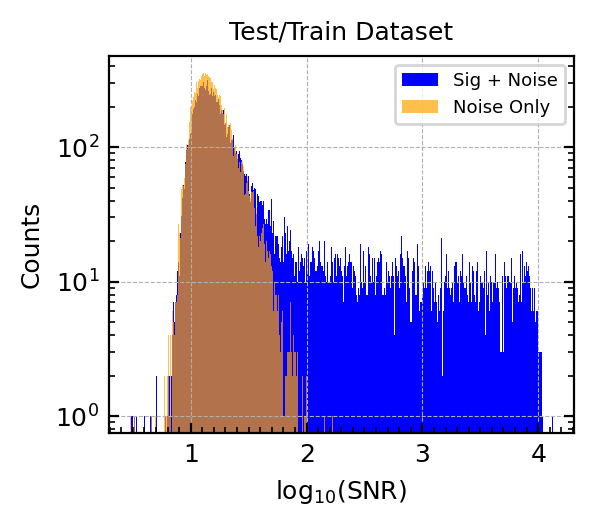

In [20]:
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

# print(int(100*np.log10((np.max(SNR_SigPlusNoise[den_ch])-np.min(SNR_SigPlusNoise[den_ch])))))
# print(int(100*np.log10((np.max(SNR_Background[den_ch])-np.min(SNR_Background[den_ch])))))

if antennaSeparated:
    ax.hist(np.log10(SNR_SigPlusNoise[den_ch]) ,bins=int(100*np.log10((np.max(SNR_SigPlusNoise[den_ch])-np.min(SNR_SigPlusNoise[den_ch])))), color='blue', alpha=1, label="Sig + Noise")
    ax.hist(np.log10(SNR_Background[den_ch]) ,bins=int(100*np.log10((np.max(SNR_Background[den_ch])-np.min(SNR_Background[den_ch])))), alpha=.7, color='orange', label="Noise Only")
else:
    ax.hist(np.log10(SNR_SigPlusNoise) ,bins=int(100*np.log10((np.max(SNR_SigPlusNoise)-np.min(SNR_SigPlusNoise)))), color='blue', alpha=1, label="Sig + Noise")
    ax.hist(np.log10(SNR_Background) ,bins=int(100*np.log10((np.max(SNR_Background)-np.min(SNR_Background)))), alpha=.7, color='orange', label="Noise Only")
    
# ax.hist(np.log10(SNR_SigPlusNoise) ,bins=int(np.sqrt(lower_length)), alpha=1, label="Sig + Noise")
# ax.hist(np.log10(SNR_Background) ,bins=int(np.sqrt(lower_length)), alpha=0.6, label="Noise Only")

ax.set_title("Test/Train Dataset", fontsize=9)
ax.set_yscale("log")
ax.tick_params(axis='both', which='both', direction='in',labelsize=9)
ax.yaxis.set_ticks_position('both')
ax.yaxis.grid(linestyle="--", linewidth=0.4)
ax.xaxis.grid(linestyle="--", linewidth=0.4)
ax.set_xlabel(r"log$_{10}$(SNR)", fontsize=9)
ax.set_ylabel("Counts", fontsize=9)

plt.legend(loc='best', prop={'size': 6.5});
fig.savefig(PlotsDir + '/SNRDistribution.pdf', bbox_inches='tight')

In [21]:
## Normalizing
SigPlusNoise, SFactor_SigPlusNoise = Normalize(SigPlusNoise)
Background, SFactor_Background = Normalize(Background)

### Reshaping for prediction
if antennaSeparated:
    SigPlusNoise = SigPlusNoise.reshape(SigPlusNoise.shape[0], SigPlusNoise.shape[1], 2)
    Background = Background.reshape(Background.shape[0], Background.shape[1], 2)
else:
    SigPlusNoise = SigPlusNoise.reshape(SigPlusNoise.shape[0], SigPlusNoise.shape[1], 1)
    Background = Background.reshape(Background.shape[0], Background.shape[1], 1)

In [22]:
ClassifierDir = f"/data/danakull/WaveformML/TrainingAndTesting/training/classifier/data/models/Classifier_BCE_{dataset}/"
# ClassifierDir = path + "/../testing/"
# ClassifierDir = "/mnt/janus/arehman/work/NewClassifier/All_Ant_MoreNoiseTraces/Models/"
# model = "Classifier_L=2_Fil=12_KS=160.h5"
# model = 'ClassifierMSE_Layers=4_DL=1_Fil=8_KS=33.h5'
# model = 'Classifier_v13_MSE_Layers=2_DL=1_Fil=12_KS=160.h5'
# model = 'Classifier_v11_MSE_Layers=2_DL=1_Fil=12_KS=160.h5'
# model = 'Classifier_v16_MSE_Layers=2_DL=1_Fil=12_KS=160.h5'
# model = 'ClassifierMSE_10_Layers=2_DL=1_Fil=12_KS=160.h5'
# model = 'Classifier_MSE_v17_Layers=2_DL=1_Fil=12_KS=160.h5'
# model = "Classifier_L=2_Fil=12_KS=160.h5"
# model = 'ClassifierMSE_Layers=2_DL=1_Fil=12_KS=160.h5'
# model = f'ClassifierMSE_Layers=4_DL=1_Fil=8_KS=33.h5'
# model = f'ClassifierMSE_Layers=4_DL=1_Fil=8_KS=33_ANT={ant}_lr=0.0001.h5'
model = f'Classifier_{ant}.h5'
## Load Model
Classifier = load_model(ClassifierDir + model)
print(f"Model {model} loaded")
## Predicting
SigOut = GetOutput(SigPlusNoise, Classifier)
print('SigOut done')
NoiseOut = GetOutput(Background, Classifier)
print('NoiseOut done')

print(np.shape(SigOut))
print(np.shape(NoiseOut))

2024-07-17 17:00:53.125626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 17:00:53.865845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46185 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


Model Classifier_ant3.h5 loaded


2024-07-17 17:00:55.922471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-07-17 17:00:57.134568: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


SigOut done
NoiseOut done
(14971,)
(15028,)


In [23]:
SigOut

array([0.5131151 , 0.43526608, 0.39364758, ..., 0.44579774, 0.99999905,
       0.41235155], dtype=float32)

In [24]:
NoiseOut

array([0.41798934, 0.44411907, 0.42166844, ..., 0.39592966, 0.4222541 ,
       0.43052158], dtype=float32)

In [25]:
falsepos = []
for thre in [0.51, 0.62, 0.75]:
    print(f"Thresold = {thre}, False Positive rate = {ComputePercentPositives(NoiseOut, thre)}")
    falsepos.append(round(ComputePercentPositives(NoiseOut, thre),1))

Thresold = 0.51, False Positive rate = 3.214000532339633


Thresold = 0.62, False Positive rate = 0.9116316209741815
Thresold = 0.75, False Positive rate = 0.2794783071599681


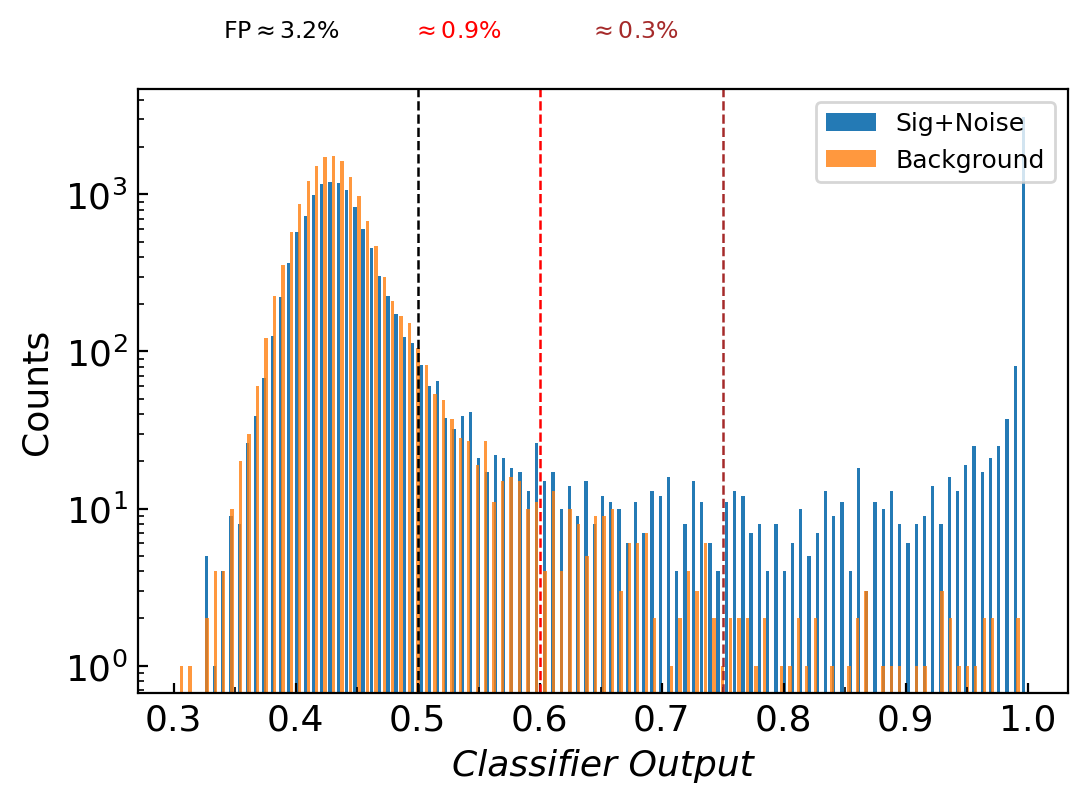

In [26]:
# %matplotlib inline
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300

fig = plt.figure()
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(0.1))

ax.hist(SigOut, bins=100, rwidth = 0.4, alpha=0.98, label="Sig+Noise")
ax.hist(NoiseOut, bins=100, rwidth = 0.4, alpha=0.8, label="Background")

ax.set_yscale('log')
ax.axvline(x=0.5,c= 'k', ls='--', lw=0.9)
ax.text(0.34, 10000, r'FP$\approx$' + f'{falsepos[0]}%', c='k', fontsize=8.5)
ax.axvline(x=0.6,c='r', ls='--', lw=0.9)
ax.text(0.495, 10000, r'$\approx$' + f'{falsepos[1]}%', c='r', fontsize=8.5)
ax.axvline(x=0.75,c='brown', ls='--', lw=0.9)
ax.text(0.64, 10000, r'$\approx$' + f'{falsepos[2]}%', c='brown', fontsize=8.5)
# ax.text(0.615, 10000, r'$\approx$0.5%', c='brown', fontsize=11)

ax.legend(loc='best', prop={'size': 9})

ax.set_xlabel("Classifier Output", fontsize=13, fontstyle='oblique')
ax.set_ylabel("Counts", fontsize=13)
# ax.text(0.31, 5000, r'FP$\approx$3.4%   1.6%  0.8%', c='b', fontsize=11)
ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
fig.savefig(PlotsDir + '/ClassifierOutput.pdf', bbox_inches='tight')

In [27]:
#####################################
# True Positives and False Positives
#####################################
## Bin the Sig + Noise data
centers = np.linspace( np.log10(min(SNR_SigPlusNoise[0])), np.log10(max(SNR_SigPlusNoise[0]))-0.5, 15)
# centers = np.linspace( 1, 3.5, 15)

CLOut_Sig = [[] for i in range(len(centers))]  ## Binning the classifier output
SNR_Sig = [[] for i in range(len(centers))]
for i in range(len(SNR_SigPlusNoise[0])):
    icenter = np.argmin(np.abs(np.log10(SNR_SigPlusNoise[0][i])-centers))
    CLOut_Sig[icenter].append(SigOut[i])
    SNR_Sig[icenter].append(SNR_SigPlusNoise[0][i]) 

## For Background binning
centers = np.linspace( np.log10(min(SNR_Background[0]))+0.1, np.log10(max(SNR_Background[0]))-0.2, 8)
# centers = np.linspace( 1, 2, 8)

CLOut_Noise = [[] for i in range(len(centers))]  ## Classifier output binned
SNR_Noise = [[] for i in range(len(centers))]

for i in range(len(SNR_Background[0])):
    icenter = np.argmin(np.abs(np.log10(SNR_Background[0][i])-centers))
    CLOut_Noise[icenter].append(NoiseOut[i])
    SNR_Noise[icenter].append(SNR_Background[0][i])

## Get TP and FP
TruePositive = []
for Bin in CLOut_Sig:   ## For Sig Traces
    TruePositive.append(ComputePercentPositives(Bin, 0.5))
    
FalsePositive = []
for Bin in CLOut_Noise: ## For background
    FalsePositive.append(ComputePercentPositives(Bin, 0.5))

#### Bin Centers for x axis (SNR values)
Sig_BinCenters = [np.mean(elem) for elem in SNR_Sig]
Noise_BinCenters = [np.mean(elem) for elem in SNR_Noise]

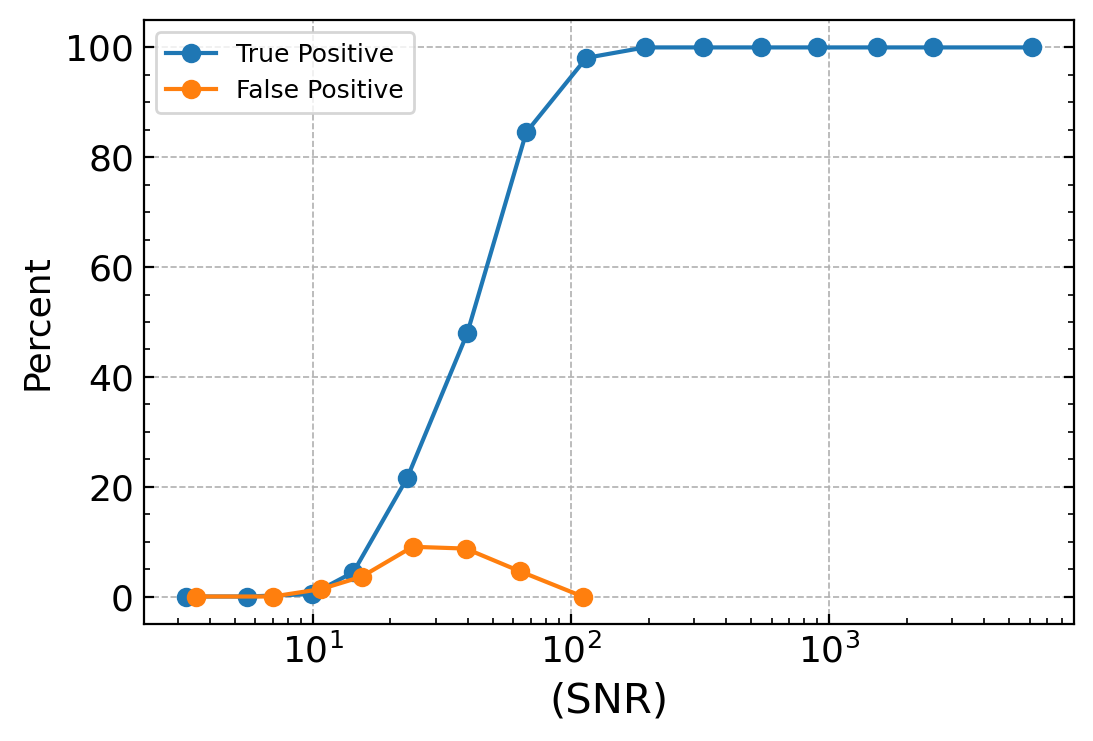

In [28]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

fig = plt.figure()
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20))

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
ax.yaxis.grid(linestyle="--", linewidth=0.6)
ax.xaxis.grid(linestyle="--", linewidth=0.6)

ax.yaxis.set_ticks_position('both')
ax.plot(Sig_BinCenters, TruePositive, '-o', label= "True Positive")
ax.plot(Noise_BinCenters, FalsePositive, '-o', label= "False Positive")
    
# ax.vlines(10**2, 0, 100, linestyles='dashed',linewidth=0.8, colors='k', alpha=0.5)  
ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel("(SNR)", fontsize=15)
ax.set_ylabel("Percent", fontsize=13)

ax.legend(loc='best', prop={'size': 9})
# ax.legend(loc='best')
ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
fig.savefig(PlotsDir + '/TruePosFalsePos.pdf', bbox_inches='tight')

# ######################### # 
# Denoiser / Decontenminator
# ########################

In [29]:
# #######################################
# Indx of traces that passes the threshold
ClassifiedIndex = [i for i in range(len(SigOut)) if SigOut[i] > 0.5] 
print("Total no of traces = %d " % len(SigPlusNoise))        
print("No of Classified traces = %d " % len(ClassifiedIndex))

Total no of traces = 14971 
No of Classified traces = 4353 


In [30]:
print(f'np.shape(SigPlusNoise)={np.shape(SigPlusNoise)}')
print(f'np.shape(SNR_SigPlusNoise)={np.shape(SNR_SigPlusNoise)}')
print(ClassifiedIndex)

np.shape(SigPlusNoise)=(14971, 1000, 2)
np.shape(SNR_SigPlusNoise)=(2, 14971)
[0, 8, 13, 14, 16, 18, 19, 27, 31, 36, 38, 39, 45, 51, 52, 55, 66, 67, 71, 73, 77, 81, 85, 91, 92, 93, 98, 100, 102, 103, 119, 124, 128, 130, 142, 143, 144, 148, 150, 155, 159, 161, 167, 168, 171, 173, 174, 175, 182, 185, 187, 189, 193, 194, 197, 200, 205, 208, 213, 215, 216, 217, 218, 223, 224, 226, 234, 236, 237, 238, 242, 245, 246, 247, 255, 256, 259, 262, 263, 268, 269, 270, 280, 281, 283, 289, 294, 297, 298, 299, 300, 301, 302, 310, 313, 314, 317, 319, 324, 327, 330, 335, 350, 359, 364, 366, 368, 371, 372, 373, 381, 382, 384, 385, 386, 394, 397, 399, 400, 403, 405, 407, 412, 424, 425, 427, 429, 430, 431, 432, 433, 438, 440, 441, 445, 446, 450, 453, 454, 456, 458, 460, 463, 464, 468, 469, 473, 474, 482, 484, 488, 489, 493, 495, 501, 503, 504, 505, 506, 507, 510, 518, 521, 525, 532, 534, 536, 539, 540, 541, 543, 545, 546, 550, 553, 555, 557, 561, 565, 569, 575, 576, 580, 586, 591, 593, 597, 604, 612, 615, 

In [31]:
# #######################################
## Select only classified traces
SigPlusNoise = SigPlusNoise[ClassifiedIndex]
SFactor_SigPlusNoise = SFactor_SigPlusNoise[ClassifiedIndex]
PureSignals = PureSignals[ClassifiedIndex]

SNR_Measured = np.array(SNR_SigPlusNoise)[:,ClassifiedIndex]
# SNR_Measured = np.array(SNR_SigPlusNoise)
print(f'np.shape(SNR_Measured)={np.shape(SNR_Measured)}')

np.shape(SNR_Measured)=(2, 4353)


In [32]:
# ## For Single channel 
# SigPlusNoise_pol0 = [SigPlusNoise[:, :, 0][i] for i in range(len(SigPlusNoise))]
# SigPlusNoise_pol1 = [SigPlusNoise[:, :, 1][i] for i in range(len(SigPlusNoise))]

# SigPlusNoise = np.concatenate((SigPlusNoise_pol0, SigPlusNoise_pol1))
# SigPlusNoise, SFactor_SigPlusNoise = Normalize(SigPlusNoise)

# PureSignals_pol0 = [PureSignals[:, :, 0][i] for i in range(len(PureSignals))]
# PureSignals_pol1 = [PureSignals[:, :, 1][i] for i in range(len(PureSignals))]

# PureSignals = np.concatenate((PureSignals_pol0, PureSignals_pol1))
# PureSignals, SFactor_PureSignals = Normalize(PureSignals)

# SNR_Measured_pol0 = [SNR_Measured[0][i] for i in range(len(SNR_Measured))]
# SNR_Measured_pol1 = [SNR_Measured[1][i] for i in range(len(SNR_Measured))]

SNR_Measured = SNR_Measured[den_ch]
SNR_SigPlusNoise = SNR_SigPlusNoise[den_ch]
SigPlusNoise = [SigPlusNoise[:, :, den_ch][i] for i in range(len(SigPlusNoise))]
# SFactor_SigPlusNoise = [SFactor_SigPlusNoise[:, :, den_ch][i] for i in range(len(SFactor_SigPlusNoise))]
PureSignals = [PureSignals[:, :, den_ch][i] for i in range(len(PureSignals))]

# SNR_Measured = np.concatenate((SNR_Measured[0], SNR_Measured[1]))
# SNR_Measured, SFactor_SNR_Measured = Normalize(SNR_Measured)


In [33]:
print(f'np.shape(SNR_Measured)={np.shape(SNR_Measured)}')
print(f'np.shape(SigPlusNoise)={np.shape(SigPlusNoise)}')

np.shape(SNR_Measured)=(4353,)
np.shape(SigPlusNoise)=(4353, 1000)


In [34]:
SigOut

array([0.5131151 , 0.43526608, 0.39364758, ..., 0.44579774, 0.99999905,
       0.41235155], dtype=float32)

In [35]:
DenoiserDir = f'/data/danakull/WaveformML/TrainingAndTesting/training/denoiser/data/models/Denoiser_MSE_{dataset}/'
# DenoiserDir = ClassifierDir
# DenoiserDir = "/mnt/janus/arehman/work/NewDenoiser/Models/"

# DenoiserModel = 'Denoiser_MSE_Auger_v3_Fil=8_KS=33_Layers=3_v4.h5'
# DenoiserModel = 'Denoiser_MSE_Auger_v4_Fil=6_KS=140_Layers=3_v4.h5'
# DenoiserModel = f'Denoiser_MSE_Auger_v3_Fil=8_KS=33_Layers=3_ANT={ant}.h5'
# DenoiserModel = f'Denoiser_MSE_{dataset}_Fil=6_KS=140_Layers=3_ANT={ant}.h5'
DenoiserModel = f'Denoiser_{ant}.h5'

SigPlusNoise = np.reshape(SigPlusNoise, (np.shape(SigPlusNoise)[0], np.shape(SigPlusNoise)[1],1))

# Denoiser = load_model(DenoiserDir + DenoiserModel, custom_objects={'CorrCoeff':CorrCoeff})
Denoiser = load_model(DenoiserDir + DenoiserModel, custom_objects={'CC2':CC2})
## Predicting
# DenoisedWaveforms = Denoiser.predict(SigPlusNoise)
DenoisedWaveforms = Denoiser.predict(SigPlusNoise)
# print(f'np.shape(SigPlusNoise)={np.shape(SigPlusNoise)}')
print(f'np.shape(DenoisedWaveforms)={np.shape(DenoisedWaveforms)}')
################################
# ReShaping The Denoised Traces
###############################
if antennaSeparated:
    denoisedSig = [DenoisedWaveforms[i].reshape(len(DenoisedWaveforms[i]),1) for i in tqdm(range(len(DenoisedWaveforms)))]
else:
    denoisedSig = [DenoisedWaveforms[i].reshape(len(DenoisedWaveforms[i]),) for i in tqdm(range(len(DenoisedWaveforms)))]
# denoisedSig = [trace.reshape(len(trace), ) for trace in DenoisedWaveforms]

# denoisedSig = DenoisedWaveforms
# denoisedSig = np.array(denoisedSig)

# if antennaSeparated:
#     # Use only the specified channel
#     def GetChannel(traces, ch):
#         traces = np.reshape(traces, (np.shape(traces)[2], np.shape(traces)[0],np.shape(traces)[1]))
#         traces = np.array(traces[ch])
#         return traces

#     denoisedSig = GetChannel(denoisedSig, den_ch)
#     SigPlusNoise = GetChannel(SigPlusNoise, den_ch)
#     PureSignals = GetChannel(PureSignals, den_ch)
#     print(f'np.shape(denoisedSig)={np.shape(denoisedSig)}')

# denoisedSig = np.array(denoisedSig)

### Rescaling traces
# NoisyTraces = []
# DenoisedTraces = []
# for i in range(len(SigPlusNoise)):
#     NoisyTraces.append(SigPlusNoise[i] * SFactor_SigPlusNoise[i])
#     DenoisedTraces.append(denoisedSig[i] * SFactor_SigPlusNoise[i])
    
# NoisyTraces = [SigPlusNoise[i] * SFactor_SigPlusNoise[i] for i in tqdm(range(len(SigPlusNoise)))]

print(f'len(SigPlusNoise)={len(SigPlusNoise)}')
print(f'len(denoisedSig)={len(denoisedSig)}')

# NoisyTraces = [SigPlusNoise_input[i] * SFactor_SigPlusNoise[i] for i in tqdm(range(len(SigPlusNoise)))]
# DenoisedTraces = [denoisedSig[i] * SFactor_SigPlusNoise[i] for i in tqdm(range(len(SigPlusNoise)))]
NoisyTraces = [SigPlusNoise[i] * SFactor_SigPlusNoise[i] for i in tqdm(range(len(SigPlusNoise)))]
DenoisedTraces = [denoisedSig[i] * SFactor_SigPlusNoise[i] for i in tqdm(range(len(SigPlusNoise)))]

print(f'np.shape(NoisyTraces)={np.shape(NoisyTraces)}')
print(f'np.shape(DenoisedTraces)={np.shape(DenoisedTraces)}')

np.shape(DenoisedWaveforms)=(4353, 1000, 1)


100%|████| 4353/4353 [00:00<00:00, 752464.78it/s]


len(SigPlusNoise)=4353
len(denoisedSig)=4353


100%|████| 4353/4353 [00:00<00:00, 180407.75it/s]

np.shape(NoisyTraces)=(4353, 1000, 1)
np.shape(DenoisedTraces)=(4353, 1000, 1)


In [36]:
######################
### Finding Peak Times
######################
print(f'len(NoisyTraces)={np.shape(NoisyTraces)}')
print(f'len(PureSignals={np.shape(PureSignals)}')
print(f'len(DenoisedTraces)={np.shape(DenoisedTraces)}')

PeakTime_Noisy = [ np.argmax(np.abs(hilbert(trace)))*0.25 for trace in tqdm(NoisyTraces) ]
PeakTime_True = [ np.argmax(np.abs(hilbert(trace)))*0.25 for trace in tqdm(PureSignals) ]
# PeakTime_True = [ np.argmax(np.abs(hilbert(trace)))*0.25 for trace in tqdm(PureSignals) ]
PeakTime_Denoised = [ np.argmax(np.abs(hilbert(trace)))*0.25 for trace in tqdm(DenoisedTraces) ]
# PeakTime_Noisy = [ np.argmax(np.abs(hilbert(trace)))*0.25 for trace in tqdm(NoisyTraces) ]
# PeakTime_True = [ np.argmax(np.abs(hilbert(trace)))*0.25 for trace in tqdm(PureSignals) ]
# PeakTime_Denoised = [ np.argmax(np.abs(hilbert(trace)))*0.25 for trace in tqdm(DenoisedTraces) ]

print(f'PeakTime_Noisy = {np.shape(PeakTime_Noisy)}')
print(f'PeakTime_True = {np.shape(PeakTime_True)}')
print(f'PeakTime_Denoised = {np.shape(PeakTime_Denoised)}')

##### Peak Time Difference
PTdiff_TrueMinusRaw = np.array(PeakTime_True) - np.array(PeakTime_Noisy) 
PTdiff_TrueMinusDeno = np.array(PeakTime_True) - np.array(PeakTime_Denoised)

len(NoisyTraces)=(4353, 1000, 1)
len(PureSignals=(4353, 1000)
len(DenoisedTraces)=(4353, 1000, 1)


 27%|█▎   | 1174/4353 [00:00<00:00, 11737.46it/s]

100%|█████| 4353/4353 [00:00<00:00, 13630.06it/s]

PeakTime_Noisy = (4353,)
PeakTime_True = (4353,)
PeakTime_Denoised = (4353,)


In [37]:
########################
### Finding Power Ratios
########################
non_zero_denoised_signals = []

print(f'np.shape(PureSignals)={np.shape(PureSignals)}')
print(f'np.shape(DenoisedTraces)={np.shape(DenoisedTraces)}')
print(f'np.shape(NoisyTraces)={np.shape(NoisyTraces)}')

# if antennaSeparated:
#     PowerRatio_Trad = [[],[]]
#     PowerRatio_NN = [[],[]]
#     # PowerRatio_Trad = []
#     # PowerRatio_NN = []

#     print(f'np.shape(PureSignals[i][:][0])={np.shape(PureSignals[0,:][:,0])}')
#     print(f'np.shape(DenoisedTraces[i][:][0])={np.shape(DenoisedTraces[0][:])}')
#     print(f'np.shape(NoisyTraces[i][:][0])={np.shape(NoisyTraces[0][:])}')
    
#     for i in tqdm(range(len(PureSignals))):
#         pure_sig_i = PureSignals[i]
#         noisy_trace_i = NoisyTraces[i]
#         PowerRatio_Trad[0]= np.append(PowerRatio_Trad[0], GetPowerRatio(pure_sig_i[:,0], noisy_trace_i[:,0])) ##(Noisy/True)
#         PowerRatio_NN[0] = np.append(PowerRatio_NN[0], GetPowerRatio(pure_sig_i[:,0], noisy_trace_i[:,0])) ##(Noisy/True)
#         PowerRatio_Trad[1]= np.append(PowerRatio_Trad[1], GetPowerRatio(pure_sig_i[:,1], noisy_trace_i[:,1])) ##(Noisy/True)
#         PowerRatio_NN[1] = np.append(PowerRatio_NN[1], GetPowerRatio(pure_sig_i[:,1], noisy_trace_i[:,1])) ##(Noisy/True)
#         # PowerRatio_Trad[0]= np.append(PowerRatio_Trad, GetPowerRatio(pure_sig_i[:,0], noisy_trace_i[:,0])) ##(Noisy/True)
#         # PowerRatio_NN[0] = np.append(PowerRatio_NN, GetPowerRatio(pure_sig_i[:,0], noisy_trace_i[:,0])) ##(Noisy/True)
#         # PowerRatio_Trad[1]= np.append(PowerRatio_Trad, GetPowerRatio(pure_sig_i[:,1], noisy_trace_i[:,1])) ##(Noisy/True)
#         # PowerRatio_NN[1] = np.append(PowerRatio_NN, GetPowerRatio(pure_sig_i[:,1], noisy_trace_i[:,1])) ##(Noisy/True)

#     # PowerRatio_Trad= np.append(PowerRatio_Trad, [GetPowerRatio(PureSignals[i,:][:,0], NoisyTraces[i,:][:,0]) for i in tqdm(range(len(PureSignals[0])))]) ##(Noisy/True)
#     # PowerRatio_NN = np.append(PowerRatio_NN, [GetPowerRatio(PureSignals[i,:][:,0], DenoisedTraces[i,:][:,0]) for i in tqdm(range(len(PureSignals[0])))]) ##(Noisy/True)
#     # PowerRatio_Trad= np.append(PowerRatio_Trad, [GetPowerRatio(PureSignals[i,:][:,1], NoisyTraces[i,:][:,1]) for i in tqdm(range(len(PureSignals[1])))]) ##(Noisy/True)
#     # PowerRatio_NN = np.append(PowerRatio_NN, [GetPowerRatio(PureSignals[i,:][:,1], DenoisedTraces[i,:][:,1]) for i in tqdm(range(len(PureSignals[1])))]) ##(Noisy/True)
# else:
#     PowerRatio_Trad = [GetPowerRatio(PureSignals[i], NoisyTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Noisy/True) 
#     PowerRatio_NN = [GetPowerRatio(PureSignals[i], DenoisedTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Deno/True)

# PowerRatio_Trad = [GetPowerRatio(PureSignals[i], NoisyTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Noisy/True) 
# PowerRatio_NN = [GetPowerRatio(PureSignals[i], DenoisedTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Deno/True)
PowerRatio_Trad = [GetPowerRatio(PureSignals[i], NoisyTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Noisy/True) 
PowerRatio_NN = [GetPowerRatio(PureSignals[i], DenoisedTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Deno/True)

print(f'np.shape(PowerRatio_Trad)={np.shape(PowerRatio_Trad)}')
print(f'np.shape(PowerRatio_NN)={np.shape(PowerRatio_NN)}')
# Plot large power ratios

np.shape(PureSignals)=(4353, 1000)
np.shape(DenoisedTraces)=(4353, 1000, 1)
np.shape(NoisyTraces)=(4353, 1000, 1)


 53%|██▋  | 2319/4353 [00:00<00:00, 23176.76it/s]

100%|█████| 4353/4353 [00:00<00:00, 16281.86it/s]

np.shape(PowerRatio_Trad)=(4353,)
np.shape(PowerRatio_NN)=(4353,)


In [38]:
## Binning the data (with respect to SNR)
# centers = np.linspace( np.log10(min(SNR_Measured))+0.1, np.log10(max(SNR_Measured))-1.0, 10)

Leftcent = np.linspace( np.log10(min(SNR_Measured))+0.1, np.log10(100), 5) # change 6 for decreasing error bars
Rightcent = np.linspace( np.log10(100)+0.2, np.log10(max(SNR_Measured))-0.2, 4)

centers = list(Leftcent) + list(Rightcent)

PtDiff_Trad = [[] for i in range(len(centers))] ## Peak Time Difference
PtDiff_NN = [[] for i in range(len(centers))]

PWRRatio_Trad = [[] for i in range(len(centers))] ## Power Ratio
PWRRatio_NN = [[] for i in range(len(centers))]

SNRBinned = [[] for i in range(len(centers))]

print(f'np.shape(SNR_Measured)={np.shape(SNR_Measured)}')
print(f'np.shape(PowerRatio_Trad)={np.shape(PowerRatio_Trad)}')
print(f'np.shape(PowerRatio_NN)={np.shape(PowerRatio_NN)}')


for i in tqdm(range(len(SNR_Measured))):
    icenter = np.argmin(np.abs(np.log10(SNR_Measured[i])-centers))
    
    PtDiff_Trad[icenter].append(PTdiff_TrueMinusRaw[i])
    PtDiff_NN[icenter].append(PTdiff_TrueMinusDeno[i])
    
    if PowerRatio_Trad[i] == np.inf:
        print("PowerRatio_Trad[i] == inf at i =", i)
    if PowerRatio_NN[i] == np.inf:
        print("PowerRatio_NN[i] == inf at i =", i)
    if PowerRatio_Trad[i] == np.nan:
        print("PowerRatio_Trad[i] == NaN at i =", i)
    if PowerRatio_NN[i] == np.nan:
        print("PowerRatio_NN[i] == NaN at i =", i)
    PWRRatio_Trad[icenter].append(PowerRatio_Trad[i])
    PWRRatio_NN[icenter].append(PowerRatio_NN[i])
    
    SNRBinned[icenter].append(SNR_Measured[i])

print(f'np.shape(PtDiff_Trad)={np.shape(PtDiff_Trad)}')
print(f'np.shape(PtDiff_NN)={np.shape(PtDiff_NN)}')

np.shape(SNR_Measured)=(4353,)
np.shape(PowerRatio_Trad)=(4353,)
np.shape(PowerRatio_NN)=(4353,)


100%|█████| 4353/4353 [00:00<00:00, 74997.35it/s]

np.shape(PtDiff_Trad)=(9,)
np.shape(PtDiff_NN)=(9,)



/home/danakull/.conda/envs/tf-gpu-2.7.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [39]:
# TdiffMean_Trad = [np.mean(entry) for entry in PtDiff_Trad]
# TdiffStd_Trad = [np.std(entry) for entry in PtDiff_Trad]

# TdiffMean_NN = [np.mean(entry) for entry in PtDiff_NN]
# TdiffStd_NN = [np.std(entry) for entry in PtDiff_NN]

In [40]:
SNRBinCenters = [np.median(elem) for elem in SNRBinned]
####################### Arrival Time Diff ######################################
### Traditional
TdiffMean_Trad, TdiffStd_Trad = [], []
YerrLow, YerrHigh = [], []
for entry in PtDiff_Trad:
    entry.sort() ## Sorting
    TdiffMean_Trad.append( entry[int(len(entry)*0.5)] ) ### Mean (Median)
    TdiffStd_Trad.append( entry[int(len(entry)*0.84)] - entry[int(len(entry)*0.16)] ) ### 68% containment
    YerrHigh.append( entry[int(len(entry)*0.84)] - entry[int(len(entry)*0.5)] ) ## difference from the medain
    YerrLow.append( entry[int(len(entry)*0.5)] - entry[int(len(entry)*0.16)] )## difference from the medain

### NN Method
TdiffMean_NN, TdiffStd_NN = [], []
YerrLow_NN, YerrHigh_NN = [], []
for entry in PtDiff_NN:
    entry.sort() ## Sorting
    TdiffMean_NN.append( entry[int(len(entry)*0.5)] ) ### Mean (Median)
    TdiffStd_NN.append( entry[int(len(entry)*0.84)] - entry[int(len(entry)*0.16)] ) ### 68% containment
    YerrHigh_NN.append( entry[int(len(entry)*0.84)] - entry[int(len(entry)*0.5)] ) ## difference from the medain
    YerrLow_NN.append( entry[int(len(entry)*0.5)] - entry[int(len(entry)*0.16)] )## difference from the medain

####################   Power Ratio ############################################
### Traditional
PowerRatioMean_Trad, PowerRatioStd_Trad = [], []
elow, ehigh =[], []
for elem in PWRRatio_Trad:
    elem.sort()
    PowerRatioMean_Trad.append( elem[int(len(elem)*0.5)] )
    PowerRatioStd_Trad.append( elem[int(len(elem)*0.84)] - elem[int(len(elem)*0.16)] )
    ehigh.append( elem[int(len(elem)*0.84)] - elem[int(len(elem)*0.5)] )
    elow.append( elem[int(len(elem)*0.5)] - elem[int(len(elem)*0.16)] )
    
### NN Method
PowerRatioMean_NN, PowerRatioStd_NN = [], []
elowNN, ehighNN =[], []
for elem in PWRRatio_NN:   ### NN method
    elem.sort()
    PowerRatioMean_NN.append( elem[int(len(elem)*0.5)] )
    PowerRatioStd_NN.append( elem[int(len(elem)*0.84)] - elem[int(len(elem)*0.16)] )
    ehighNN.append( elem[int(len(elem)*0.84)] - elem[int(len(elem)*0.5)] )
    elowNN.append( elem[int(len(elem)*0.5)] - elem[int(len(elem)*0.16)] )
################################################################

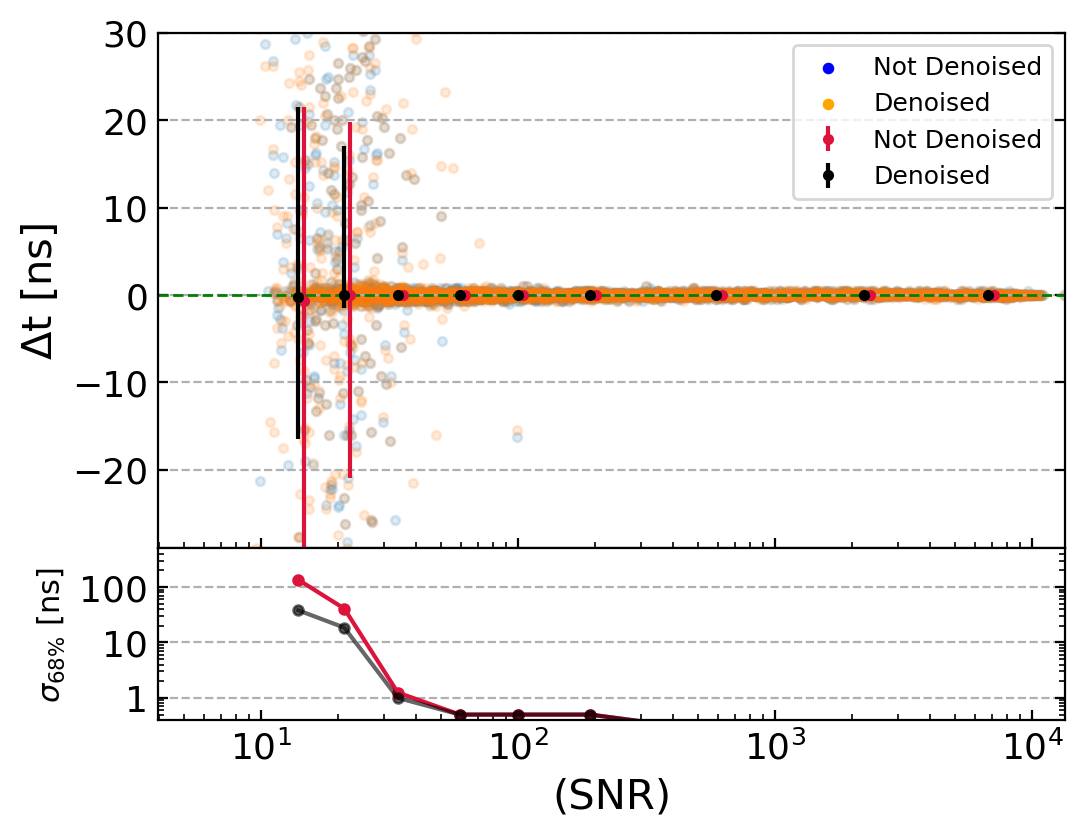

In [41]:
from matplotlib.ticker import MultipleLocator

gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0, width_ratios=[1], height_ratios=[0.75, 0.25])
fig = plt.figure(figsize=(9*0.65, 7*0.65))
ax = fig.add_subplot(gs[0])
ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', direction='in',labelsize=13)

# ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_minor_locator(MultipleLocator(10))

ax.scatter(SNR_Measured, PTdiff_TrueMinusRaw,  s=10, alpha=0.15)
ax.scatter(SNR_Measured, PTdiff_TrueMinusDeno, s=10, alpha=0.15)
ax.scatter([], [], c='b', s=10, label='Not Denoised') ## For showing the labels, remove the earlier label
ax.scatter([], [], c='orange', s=10, label='Denoised') ## For showing the labels, remove the earlier label

ax.errorbar(np.array(SNRBinCenters)*1.05, TdiffMean_Trad, yerr=[YerrLow, YerrHigh], c='crimson',  fmt='.',capthick=0.5, label='Not Denoised')
ax.errorbar(SNRBinCenters, TdiffMean_NN, yerr=[YerrLow_NN, YerrHigh_NN], c='k',  fmt='.',capthick=0.5, label='Denoised')

ax.axhline(0, ls='dashed', lw=1, color='g')
ax.yaxis.grid(linestyle="--")
ax.yaxis.set_ticks_position('both')


ax.set_xscale('log')
ax.set_ylim(-29,30)
# ax.set_ylim(-249,250)

ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_ylabel(r"$\Delta$t [ns]", fontsize=15)
ax.legend(loc='best', prop={'size': 9})
ax.tick_params(axis='both', which='both', direction='in',labelsize=13);


ax = fig.add_subplot(gs[1])
ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
ax.yaxis.grid(linestyle="--")
ax.yaxis.set_ticks_position('both')

## For setting minor ticks
import matplotlib
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

## For setting manual ticks

# from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_ticks([1, 10, 100])
ax.set_yticklabels(['1', '10','100'])


ax.plot(SNRBinCenters, TdiffStd_Trad, '-o',c='crimson', markersize=3.5,alpha=1)
ax.plot(SNRBinCenters, TdiffStd_NN, '-o',c='k', markersize=3.5,alpha=0.6)


ax.set_ylim(0.4, 500)
ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_xlabel("(SNR)", fontsize=15)
# ax.set_ylabel(r"$\sigma$ [ns]", fontsize=15)
ax.set_ylabel(r"$\sigma_{\rm 68\%}$ [ns]", fontsize=11);
fig.savefig(PlotsDir + '/TimeDiff.pdf', bbox_inches='tight')

In [42]:
def PlotDenoised(ax_idx, snr, t_diff):
    ax = fig.add_subplot(gs[ax_idx])
    Y1, Y2 = np.array(NoisyTraces[i])/1e-12, np.array(DenoisedTraces[i])/1e-12  # --> In mV
    ax.set_title(f"SNR = {snr:.2f}, " + r"$\Delta$t" + f" = {t_diff:.2f}", fontsize=14)
    ax.plot( Y1 , c='blue', label="Sig+Noise")
    ax.plot( Y2 , c='darkorange', label="Denoised")
    ax.set_ylim(-1.1*max(Y1), 1.1*max(Y1))
    ax.set_xlabel("Time Bins")
    ax.set_ylabel(r"Amplitude (mV)")
    ax.legend(loc='best', prop={'size': 8})

In [43]:
NRows = 4
NCols = 2
gs = gridspec.GridSpec(NRows, NCols, wspace=0.2, hspace=0.3)
fig = plt.figure(figsize=(6*NCols, 5*NRows))

num_plots = 0
for i in range(len(PTdiff_TrueMinusDeno)):
    t_diff = PTdiff_TrueMinusDeno[i]
    snr = SNR_SigPlusNoise[i]
    if ((3<t_diff<5) or (-5<t_diff<-3)) and snr > (10**4.) and num_plots < 8:
        PlotDenoised(num_plots, snr, t_diff)
        num_plots += 1

<Figure size 2400x4000 with 0 Axes>

In [44]:
import pandas as pd
## Check for NaNs
if np.isnan(SNR_Measured).any() or np.isinf(SNR_Measured).any():
    print('NaN(s) or inf found in SNR_Measured array')
if np.isnan(PowerRatio_Trad).any() or np.isinf(PowerRatio_Trad).any():
    print('NaN(s) or inf found in PowerRatio_Trad array')
    print(np.isnan(PowerRatio_Trad))
if np.isnan(PowerRatio_NN).any() or np.isinf(PowerRatio_NN).any():
    print('NaN(s) or inf found in PowerRatio_NN array')
    print(np.isnan(PowerRatio_NN))

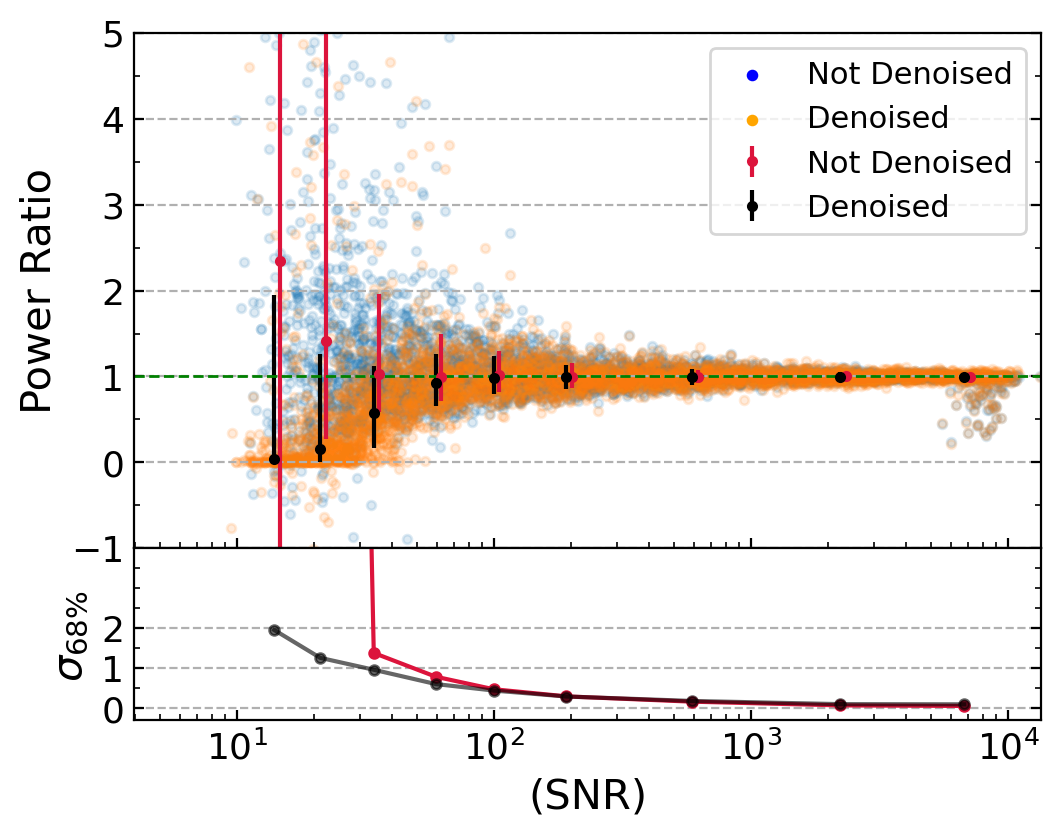

In [45]:
from matplotlib.ticker import MultipleLocator

gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0, width_ratios=[1], height_ratios=[0.75, 0.25])
fig = plt.figure(figsize=(9*0.65, 7*0.65))
ax = fig.add_subplot(gs[0])
ax.set_xticklabels([])
ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_ticks_position('both')

ax.scatter(SNR_Measured, PowerRatio_Trad,s=10, alpha=0.15)
ax.scatter(SNR_Measured, PowerRatio_NN,s=10, alpha=0.15)
ax.scatter([], [], c='b', s=10, label='Not Denoised') ## For showing the labels, remove the earlier label
ax.scatter([], [], c='orange', s=10, label='Denoised') ## For showing the labels, remove the earlier label

ax.errorbar(np.array(SNRBinCenters)*1.05, PowerRatioMean_Trad, yerr=[elow, ehigh], c='crimson',  fmt='.',capthick=0.5, label='Not Denoised')
ax.errorbar(SNRBinCenters, PowerRatioMean_NN, yerr=[elowNN, ehighNN], c='k',  fmt='.',capthick=0.5, label='Denoised')

ax.axhline(1.0, ls='dashed', lw=1, color='g')


ax.set_xscale('log')
ax.set_ylim(-1,5)
ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_ylabel("Power Ratio", fontsize=15)
ax.legend(loc='best', prop={'size': 11})
ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
ax.yaxis.grid(linestyle="--")


ax = fig.add_subplot(gs[1])
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_ticks_position('both')

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);

ax.plot(SNRBinCenters, PowerRatioStd_Trad, '-o',c='crimson', markersize=3.5,alpha=1)
ax.plot(SNRBinCenters, PowerRatioStd_NN, '-o',c='k', markersize=3.5,alpha=0.6)
ax.set_yticks([0,1,2])
ax.yaxis.grid(linestyle="--")

ax.set_xscale('log')
ax.set_ylim(-0.3,4)
ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_xlabel("(SNR)", fontsize=15)
ax.set_ylabel(r"$\sigma_{\rm 68\%}$ ", fontsize=15);
fig.savefig(PlotsDir + '/PowerRatio.pdf', bbox_inches='tight')

In [46]:
len(PTdiff_TrueMinusDeno), len(PowerRatio_NN), len(SNR_Measured)

(4353, 4353, 4353)

In [47]:
Ind = []
for i in range(len(SNR_Measured)):
    if SNR_Measured[i] < 1*10**1:
        if PTdiff_TrueMinusDeno[i] < 5:
            if PowerRatio_NN[i] > 0.95 and PowerRatio_NN[i] < 1.05:
                Ind.append(i)

In [48]:
# print(Ind)

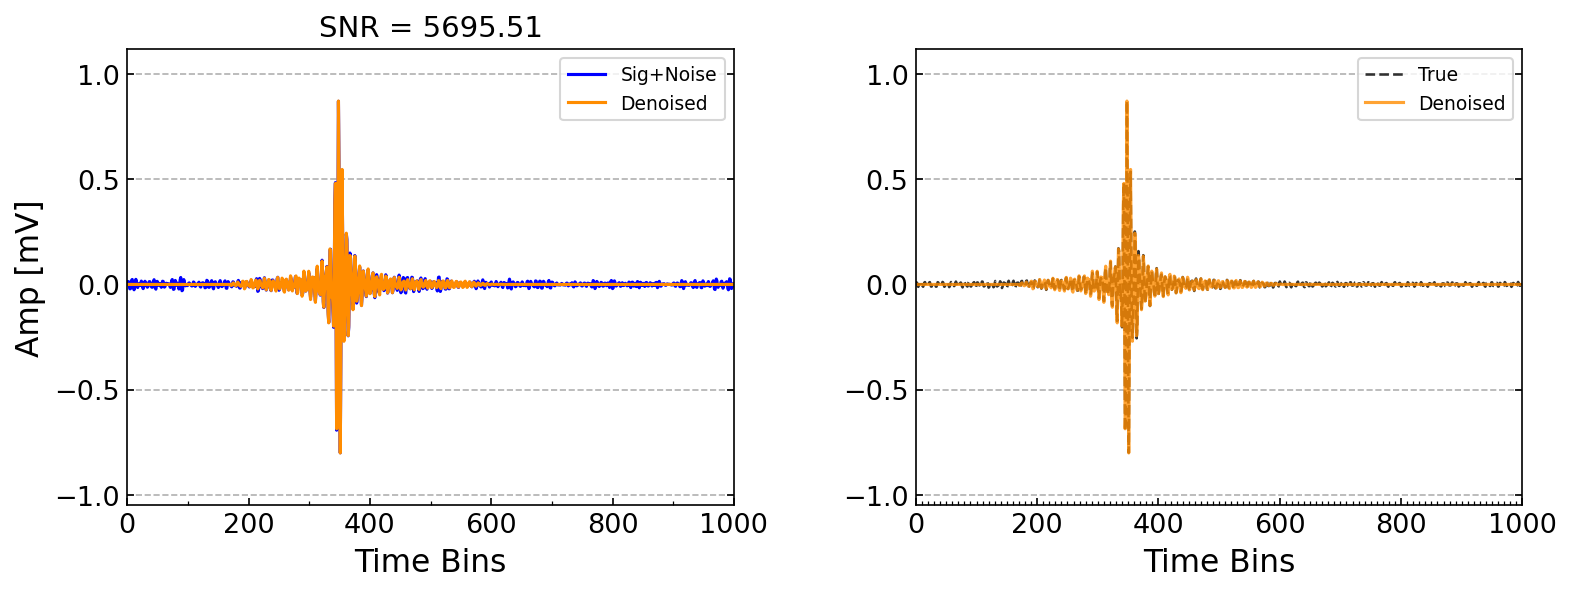

In [49]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

from matplotlib.ticker import MultipleLocator

NRows = 5
NCols = 2
gs = gridspec.GridSpec(NRows, NCols, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=(6*NCols, 5*NRows))

i_ax = 0
for i in range(len(SNR_Measured)):
# for i in Ind[:5]:
    snr = SNR_Measured[i]
    if snr<1843:
        continue
    if i > 4:
        break
#     NRows, NCols = 5, 2
#     gs = gridspec.GridSpec(NRows, NCols, wspace=0.3, hspace=0.3)
#     fig = plt.figure(figsize=(6*NCols, 3*NRows))
    ax = fig.add_subplot(gs[i_ax])

    Y1, Y2 = np.array(NoisyTraces[ i ])/1e-12, np.array(DenoisedTraces[ i ])/1e-12  # --> In mV
    
    ax.set_title("SNR = {:.2f}".format(snr), fontsize=14)
    ax.plot( Y1 , c='blue', label="Sig+Noise")
    ax.plot( Y2 , c='darkorange', label="Denoised")

    ax.legend(loc=0, prop={'size': 9})
    ax.set_xlabel("Time Bins", fontsize=15)
    ax.set_ylabel("Amp [mV]", fontsize=15)
    
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    ax.yaxis.grid(linestyle="--")
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    
    
    Ymin, Ymax =  min(Y1)-.25, max(Y1)+.25
    ax.set_ylim( Ymin ,  Ymax )
    ax.set_xlim(0, 1000)
    
    i_ax += 1
##############################################################################################
########### 2nd Column
    ax = fig.add_subplot(gs[i_ax])
    
    Y1, Y2 = np.array(PureSignals[ i ])/1e-12 , np.array(DenoisedTraces[ i ])/1e-12
    
    ax.plot( Y1 ,"--", c='k', alpha=0.8,linewidth=1.25, label="True")
    ax.plot( Y2 , c='darkorange',alpha=0.8, label="Denoised")

    ax.legend(loc=0, prop={'size': 9})
    ax.set_xlabel("Time Bins", fontsize=15)
    ###### x-limit 
    signal_middle = np.argmax( Y1 )
    ax.set_xlim( signal_middle-150, signal_middle+150 )

    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    ax.yaxis.set_ticks_position('both')

    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.grid(linestyle="--")
    
    ax.set_ylim( Ymin ,  Ymax )
    ax.set_xlim(0, 1000)
    i_ax += 1

plt.savefig(PlotsDir + '/ExampleTraces.pdf', bbox_inches='tight')

In [50]:
Ind = []
for i in range(len(SNR_Measured)):
    if SNR_Measured[i] < 1*10**1:
        Ind.append(i)

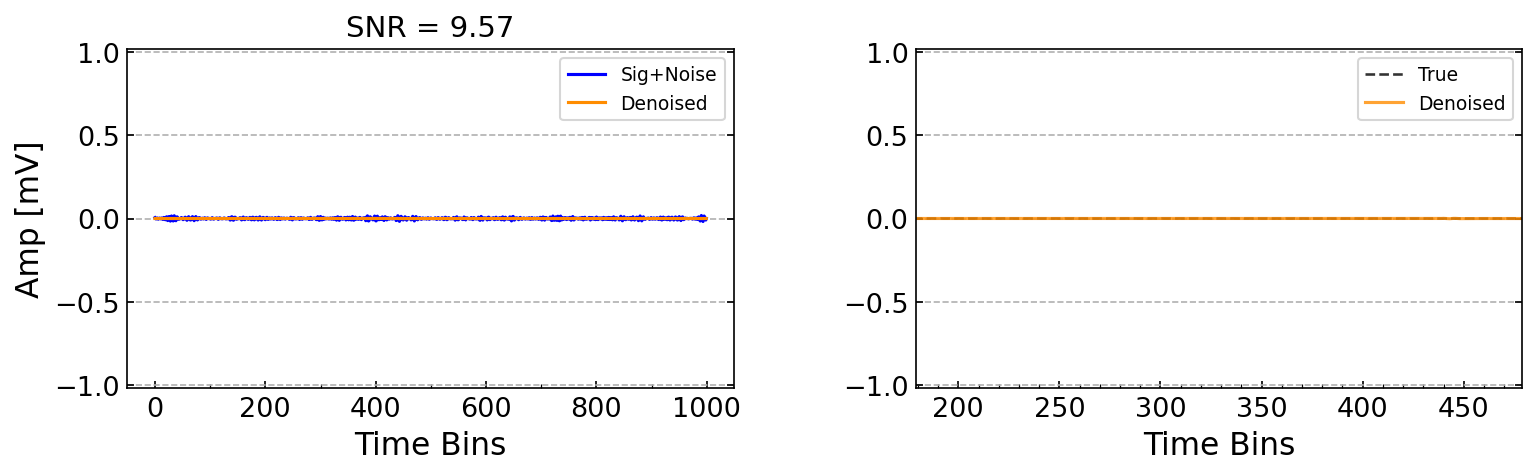

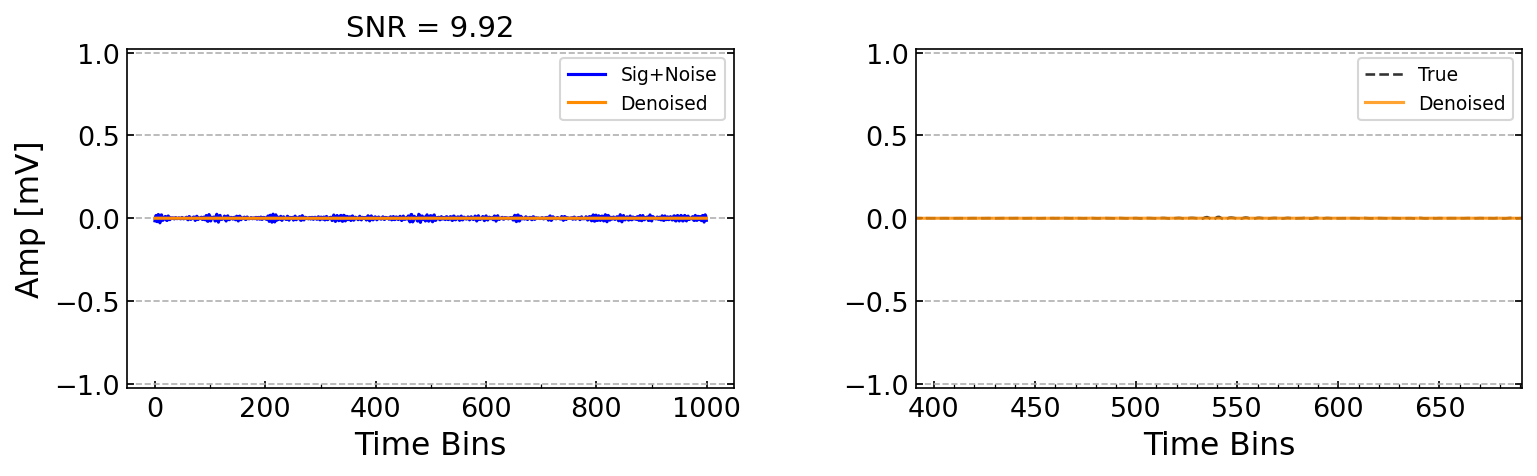

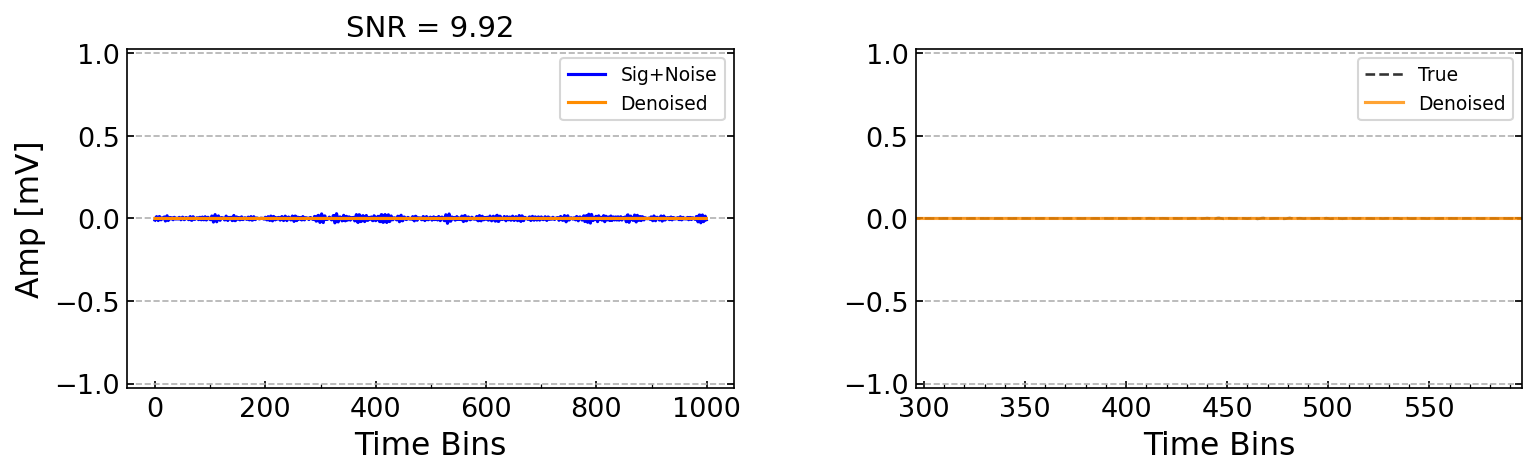

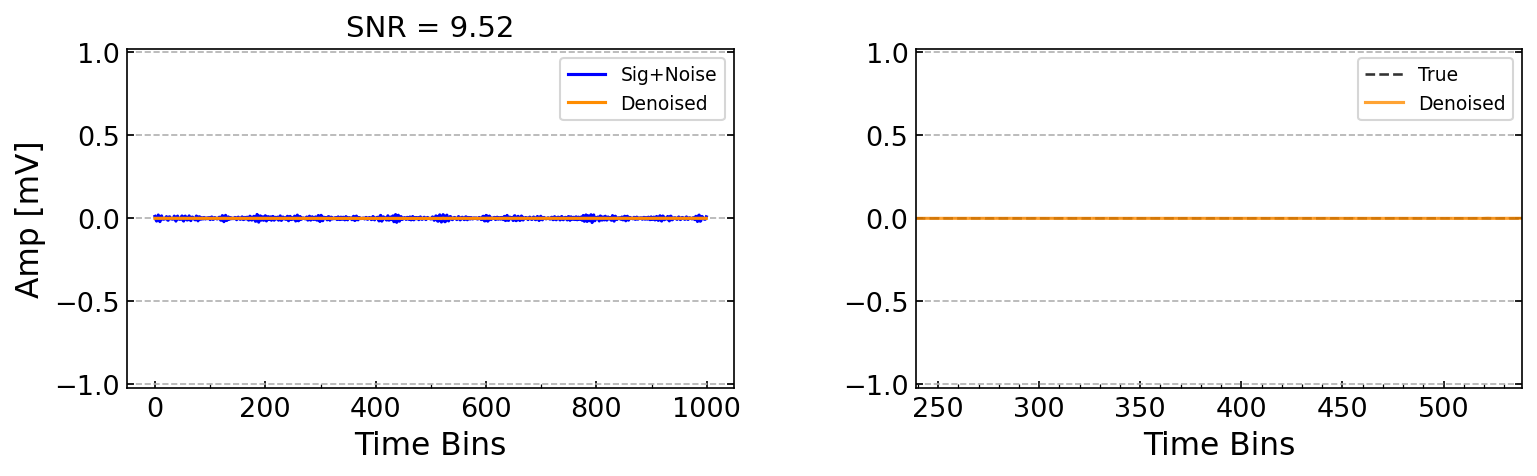

In [51]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

from matplotlib.ticker import MultipleLocator

for i in Ind[:15]:

    snr = SNR_Measured[i]

    NRows, NCols = 1, 2
    gs = gridspec.GridSpec(NRows, NCols, wspace=0.3, hspace=0.3)
    fig = plt.figure(figsize=(6*NCols, 3*NRows))
    ax = fig.add_subplot(gs[0])

    Y1, Y2 = np.array(NoisyTraces[ i ])/1e-12, np.array(DenoisedTraces[ i ])/1e-12  # --> In mV
    
    ax.set_title("SNR = {:.2f}".format(snr), fontsize=14)
    ax.plot( Y1 , c='blue', label="Sig+Noise")
    ax.plot( Y2 , c='darkorange', label="Denoised")

    ax.legend(loc=0, prop={'size': 9})
    ax.set_xlabel("Time Bins", fontsize=15)
    ax.set_ylabel("Amp [mV]", fontsize=15)
    
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    ax.yaxis.grid(linestyle="--")
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    
    
    Ymin, Ymax =  min(Y1)-1, max(Y1)+1
    ax.set_ylim( Ymin ,  Ymax )
##############################################################################################
########### 2nd Column
    ax = fig.add_subplot(gs[1])
    
    Y1, Y2 = np.array(PureSignals[ i ])/1e-12 , np.array(DenoisedTraces[ i ])/1e-12
    
    ax.plot( Y1 ,"--", c='k', alpha=0.8,linewidth=1.25, label="True")
    ax.plot( Y2 , c='darkorange',alpha=0.8, label="Denoised")

    ax.legend(loc=0, prop={'size': 9})
    ax.set_xlabel("Time Bins", fontsize=15)
    ###### x-limit 
    signal_middle = np.argmax( Y1 )
    ax.set_xlim( signal_middle-150, signal_middle+150 )

    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    ax.yaxis.set_ticks_position('both')

    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.grid(linestyle="--")
    
    ax.set_ylim( Ymin ,  Ymax )
    
#     plt.savefig('./Eg1.pdf' , bbox_inches='tight');    

In [52]:
DNT = [np.array(i)/1e-12 for i in DenoisedTraces]

In [53]:
FPeaks_Indx = []
for i in range(len(DNT)):
    Peak = np.max(DNT[i])
    if Peak > 5:
        PeakLoc = np.argmax(DNT[i])
        if PeakLoc > 500 and PeakLoc < 3500:
            XX = DenoisedTraces[i]
            Peak2 = np.max(list(XX[0:PeakLoc-200]) + list(XX[PeakLoc+200:]))
            if Peak2 / Peak  > 0.5:
#                 print(i)
                FPeaks_Indx.append(i)